In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def filter_df(df):
    max=49
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
m_data = data.query('age < 95').copy()
#m_data = data.copy()

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
f_data = data.query('age < 95').copy()
#f_data = data.copy()

In [6]:
# arrange data
m_data = m_data.groupby(['age','uuid']).mean()
f_data = f_data.groupby(['age','uuid']).mean()

f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
#f_ages[f_ages==72]=78 


In [7]:
# look at syllable usage diff male and females according to actual age
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
diff_age =m_data.groupby('age').mean().to_numpy()-f_data.groupby('age').mean().to_numpy()

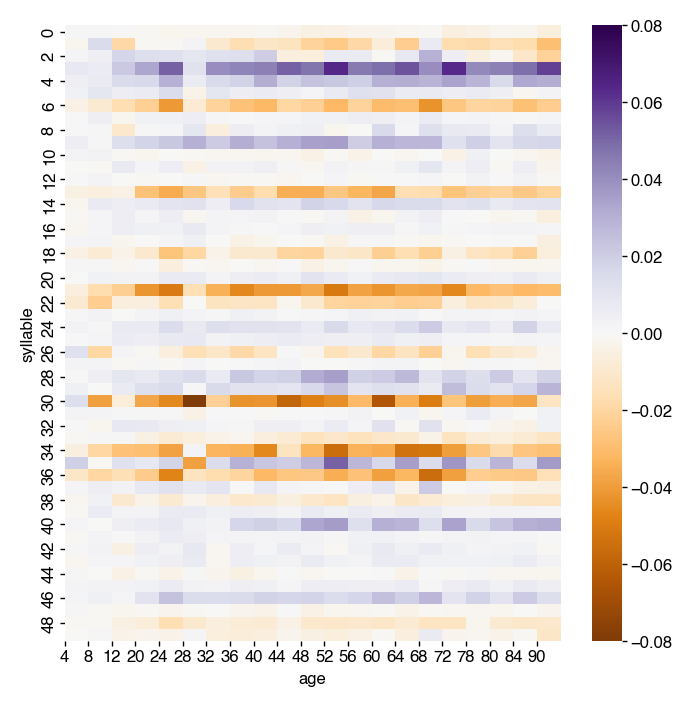

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
sns.heatmap(diff_age.T, cmap ='PuOr', 
            vmin=-0.08, 
            vmax=0.08
           )
plt.xlabel('age')
plt.ylabel('syllable')
#plt.xticks(x_values, custom_labels)
plt.xticks(list(range(len(cages))),cages)
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_syll_diff__over_life_heatmap.pdf')

In [9]:
def normalize_matrix(matrix):
    # Find the minimum and maximum values in the matrix
    min_value = np.min(matrix)
    max_value = np.max(matrix)
    
    # Normalize the matrix using the formula
    normalized_matrix = (matrix - min_value) / (max_value - min_value) * 2 - 1
    
    return normalized_matrix

new_diff = normalize_matrix(diff_age)

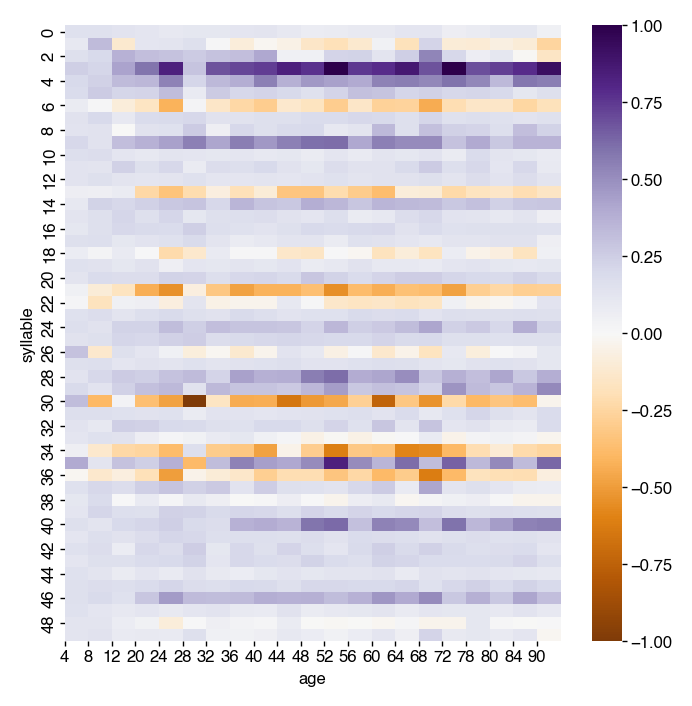

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
sns.heatmap(new_diff.T, cmap ='PuOr')
plt.xlabel('age')
plt.ylabel('syllable')
#plt.xticks(x_values, custom_labels)
plt.xticks(list(range(len(cages))),cages)
c = PlotConfig()

In [11]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_syll_diff__over_life_heatmap_normalized.pdf')

In [12]:
## with clustering based on sylabble change

<Figure size 1200x1200 with 0 Axes>

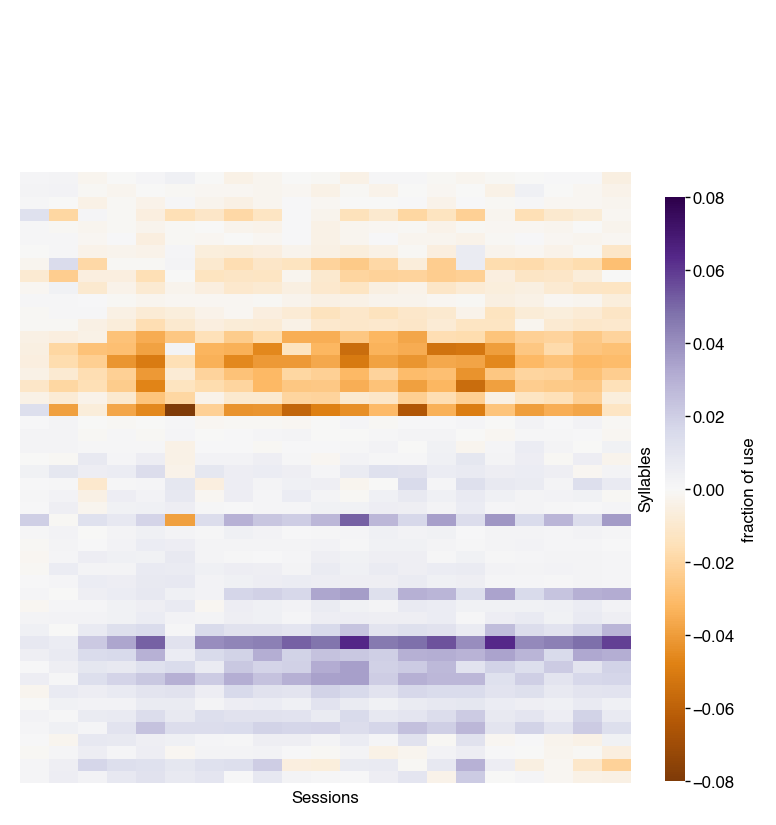

In [13]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=diff_age.T,
    cmap='PuOr', 
    figsize=(4, 4),
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=True,
    yticklabels=False,
    xticklabels=False,
    #method='average',
    method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.08,
    vmin=-0.08,
)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_syll_diff__over_life_heatmap_clustered.pdf')